# DA623 Assignment
## Demonstrate Principal Component Analysis as a Regression Approach

### Motivation :

Principal Component Analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. 

PCA as a regression approach, also known as Principal Component Regression (PCR), is a technique that combines PCA and linear regression. 
The main advantage of PCR is that it can help to overcome the overfitting problem when the independent variables are highly correlated. It does this by reducing the dimensionality of the data, removing multicollinearity, and improving model interpretability.

However, one downside of PCR is that the principal components are less interpretable than the original features, as they are linear combinations of the original variables.
Nevertheless, with this motivation, we shall begin this tutorial. 
In this tutorial, we will be performing PCR on a Car Pricing Dataset. We can particularly see, how PCA helps bring down the dimensionality of the dataset for regression. There are many independent variables like wheelbase, carlength, engine size and so on. We will bring the number of features down from 71 to 4, and still be able to explain 99.94% of the variance! Isn't that cool?

### Objectives :
In this tutorial, we will :
1. Perform some initial pre-processing on the dataset to make it suitable for PCR.
2. Standardize the data (mean = 0 and standard deviation = 1).
3. Perform PCA on the independent variables to generate the principal components.
4. Select a subset of the principal components as predictors based on some criterion, such as the cumulative variance explained or the eigenvalues of the components.
5. Perform linear regression using the selected principal components as predictors.

In [397]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

### Preprocessing
First, we will perform some preliminary pre-processing on the dataset to make it suitable for PCR.
Then we create dummy variables for the categorical features so that we can perform regression.

In [398]:
df = pd.read_csv("./CarPrice_Assignment.csv")
X = df.drop('price', axis = 1)
y = df['price']

In [399]:
categorical_feature = df.dtypes==object
final_categorical_feature = df.columns[categorical_feature].tolist()

#--------------------------------------------------------------------------
numeric_feature = df.dtypes!=object
final_numeric_feature = df.columns[numeric_feature].tolist()


In [400]:
Company = df['CarName'].apply(lambda x : x.split()[0])
Company

0      alfa-romeo
1      alfa-romeo
2      alfa-romeo
3            audi
4            audi
          ...    
200         volvo
201         volvo
202         volvo
203         volvo
204         volvo
Name: CarName, Length: 205, dtype: object

In [401]:
df.insert(1, 'Company', Company)
df.drop(['CarName'], axis=1, inplace=True)
df.head()


,car_ID,Company,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,alfa-romeo,3,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,alfa-romeo,3,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,alfa-romeo,1,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,audi,2,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,audi,2,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [402]:
df['Company'].unique()

array(['alfa-romeo', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche', 'renault',
       'saab', 'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [403]:
final_categorical_feature.append('Company')
final_categorical_feature.remove('CarName')
final_categorical_feature

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'Company']

In [404]:
df_dummy = pd.get_dummies(df, prefix=final_categorical_feature, columns=final_categorical_feature, drop_first=True)
df_dummy.head()


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,...,Company_nissan,Company_peugeot,Company_plymouth,Company_porsche,Company_renault,Company_saab,Company_subaru,Company_toyota,Company_volkswagen,Company_volvo
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,0,0,0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,0,0,0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,0,0,0,0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,0,0,0,0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,0,0,0,0


In [405]:
X = df_dummy.drop("price", axis = 1)
y = df_dummy['price']

So as we can see, the number of samples we have, and the number of features we have before performing PCA are as follows :

In [406]:
n_samples, n_features = X.shape

print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 205
Number of features: 66


We can see the explanatory variables/ independent variable values as follows :

In [407]:
X

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,...,Company_nissan,Company_peugeot,Company_plymouth,Company_porsche,Company_renault,Company_saab,Company_subaru,Company_toyota,Company_volkswagen,Company_volvo
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,0,0,0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,0,0,0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,0,0,0,0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,0,0,0,0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,109.1,188.8,68.9,55.5,2952,141,3.78,3.15,...,0,0,0,0,0,0,0,0,0,1
201,202,-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,...,0,0,0,0,0,0,0,0,0,1
202,203,-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,...,0,0,0,0,0,0,0,0,0,1
203,204,-1,109.1,188.8,68.9,55.5,3217,145,3.01,3.40,...,0,0,0,0,0,0,0,0,0,1


The corresponding dependent variable value is given as :

In [408]:
y

0      13495.0
1      16500.0
2      16500.0
3      13950.0
4      17450.0
        ...   
200    16845.0
201    19045.0
202    21485.0
203    22470.0
204    22625.0
Name: price, Length: 205, dtype: float64

### Standardisation
For PCA to work, since the principle is to get the component to maximise the covariance, we need to get the data centered at the origin. This is what we are achieving by standardisation of the data.

In [409]:
# standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

The covariance matrix is given as follows :

In [410]:
covariance_matrix = np.cov(X.T)
print('Covariance matrix: \n', covariance_matrix)

Covariance matrix: 
 [[ 3.51916667e+03 -1.12009804e+01  4.63426471e+01 ...  9.96078431e+00
   5.02941176e+00  5.23039216e+00]
 [-1.12009804e+01  1.55078910e+00 -3.98909852e+00 ... -4.26111908e-02
   4.89717838e-02 -1.13605930e-01]
 [ 4.63426471e+01 -3.98909852e+00  3.62617824e+01 ... -1.02503587e-01
  -6.75442372e-02  4.16556671e-01]
 ...
 [ 9.96078431e+00 -4.26111908e-02 -1.02503587e-01 ...  1.32376853e-01
  -9.18220947e-03 -8.41702535e-03]
 [ 5.02941176e+00  4.89717838e-02 -6.75442372e-02 ... -9.18220947e-03
   5.53802009e-02 -3.15638451e-03]
 [ 5.23039216e+00 -1.13605930e-01  4.16556671e-01 ... -8.41702535e-03
  -3.15638451e-03  5.10282162e-02]]


### Generating the principal components
First we observe the eigenvalues of the covariance matrix. The eigenvectors corresponding to the larger eigenvalues will explain most of the variance in the data. Once we have decided the number N of principal components we want, we can take the eigenvectors corresponding to the N largest eigenvalues of the covariance matrix. These will constitute the principal components of our data.

In [411]:
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)

In [412]:
print('Eigenvalues: \n', eig_vals)
print('Eigenvectors: \n', eig_vecs)

Eigenvalues: 
 [ 3.20557196e+05  1.80755009e+05  3.39261901e+03  7.72827496e+02
  1.91373245e+02  3.77444214e+01  2.34494164e+01  7.08907944e+00
  5.60534379e+00  2.89463399e+00  1.07302705e+00  8.97734603e-01
  7.67494545e-01  3.26442352e-01  2.88299913e-01  2.37712992e-01
  1.75647484e-01  1.64113502e-01  1.22141199e-01  9.93046081e-02
  9.75751672e-02  8.68526002e-02  7.59354453e-02  6.45314890e-02
  5.67059244e-02  5.43865931e-02  5.31709139e-02  4.49151549e-02
  4.38207291e-02  3.80425504e-02  3.51085299e-02  3.22685621e-02
  2.69064138e-02  2.58193547e-02  2.26689957e-02  2.00997488e-02
  1.82703873e-02  1.66998811e-02  1.57915627e-02  1.32467483e-02
  1.23037294e-02  8.93590286e-03  8.11484453e-03  6.65799657e-03
  6.41815716e-03  5.77658466e-03  5.16178643e-03  4.75581107e-03
  4.03807038e-03  3.68029344e-03  3.54840646e-03  2.94872740e-03
  2.52524318e-03  2.37375550e-03  1.93867919e-03  1.47284904e-03
  1.20389946e-03  7.99340509e-04  4.44122925e-04  2.25418893e-04
  2.054035

In [413]:
eig_vecs[1]

array([-6.69373698e-04, -2.61638426e-04,  2.16902843e-03,  1.17842560e-02,
       -1.44433024e-02,  4.09135790e-02, -6.31905094e-02, -1.76502569e-01,
        9.09980725e-02, -1.26427917e-01, -6.06681642e-01, -3.45964956e-01,
       -5.51442987e-01, -3.78704674e-02,  2.47728034e-01,  4.99919170e-02,
        1.11600294e-02,  1.19616216e-01,  1.18710463e-01,  3.45527951e-02,
       -9.65696128e-03,  7.68266928e-02, -4.68392946e-02,  9.66117206e-02,
        8.71836658e-02,  2.32273824e-02,  8.95212240e-02, -5.91565213e-03,
        2.38304598e-02, -9.90665374e-03,  1.83621262e-02, -7.27551988e-02,
        8.90181561e-03,  1.09031082e-02, -6.85970026e-03,  3.62474557e-04,
       -2.52063906e-02, -2.94963791e-02,  3.24384375e-02, -9.69469805e-03,
        2.27327836e-04, -1.55021805e-02, -5.45824495e-02, -2.25625585e-02,
       -5.96457793e-03, -2.25599555e-02, -5.46990829e-03, -5.19860433e-02,
       -4.28959194e-03,  5.99754707e-04,  1.13760290e-02,  1.81090924e-02,
        3.04540154e-02,  

In [414]:
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
max_abs_idx

array([ 6, 12,  0, 11,  7,  3, 14, 10,  2,  5,  1, 13,  4, 27, 20, 27, 32,
       37, 21,  9, 63, 53, 53, 17, 56, 55, 17, 50, 49, 18, 58, 65, 64,  9,
       51, 51, 18, 22, 29, 48, 48, 23, 60, 40, 60, 60, 54, 45, 24, 40, 34,
       43, 38, 38, 54, 35, 25, 40, 35, 25, 25, 44, 39, 26, 30, 30])

In [415]:
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
signs

array([ 1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
       -1.])

In [416]:
signs.shape

(66,)

In [417]:
print(signs[np.newaxis,:].shape)

(1, 66)


In [418]:
eig_vecs = eig_vecs*signs
eig_vecs

array([[ 1.62292577e-02, -1.92657488e-02,  9.95706968e-01, ...,
        -2.42151770e-15,  4.44196778e-15,  5.10520879e-15],
       [-6.69373698e-04,  2.61638426e-04, -2.16902843e-03, ...,
        -3.80109185e-14, -4.83854089e-15,  1.61468403e-14],
       [ 8.07751155e-03,  3.16155453e-03,  5.36552958e-03, ...,
        -2.94322124e-15, -4.11926076e-15, -3.47868946e-15],
       ...,
       [ 3.00329607e-05, -2.46878800e-04,  2.62741311e-03, ...,
         1.72191289e-13, -3.21437052e-13, -3.36401761e-13],
       [-3.48275184e-05, -3.34187104e-05,  1.50746353e-03, ...,
         2.95174578e-13, -4.15937556e-13, -4.86956415e-13],
       [ 5.02755273e-05,  1.23300357e-04,  1.61310586e-03, ...,
         1.99778759e-13, -4.50202385e-13, -4.54103505e-13]])

In [419]:
eig_vecs = eig_vecs.T

In [420]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(eig_pairs)

[(320557.1963673572, array([ 1.62292577e-02, -6.69373698e-04,  8.07751155e-03,  1.74408896e-02,
        2.87848922e-03,  1.63075590e-03,  8.11430077e-01,  5.59543771e-02,
        2.93307947e-04,  8.86235593e-05,  2.28583176e-03,  3.50818488e-02,
       -5.80073062e-01, -5.94834835e-03, -6.97784361e-03, -2.07715224e-04,
        2.27010126e-04, -2.36032540e-04,  3.25390966e-05, -2.46905807e-04,
        1.02830616e-04,  9.47552729e-05, -4.90092351e-04,  4.67170520e-04,
       -1.22608521e-05,  4.68531958e-06,  1.22429737e-04, -2.57865758e-04,
       -1.08438358e-05,  1.43219804e-04, -3.84264051e-05,  8.32493021e-05,
       -3.03479457e-04,  1.70286786e-04, -1.31460043e-05,  1.86622966e-05,
       -3.84264051e-05, -3.20609850e-04, -2.99415898e-05,  2.07715224e-04,
        4.30861978e-06,  2.81506495e-04, -1.27677647e-05,  3.29517055e-06,
        6.44151325e-06, -2.03388626e-06,  4.13900290e-05,  1.59354827e-04,
       -3.46585477e-05, -6.66878379e-05, -1.47264079e-04, -1.80774380e-05,
    

We can select the principal components as stated before using the cumulative explained variance. The graph is shown below :

Explained variance: [6.338e+01 3.574e+01 6.700e-01 1.500e-01 4.000e-02 1.000e-02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
Cumulative explained variance: [63.38 99.12 99.79 99.94 99.98 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99
 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.9

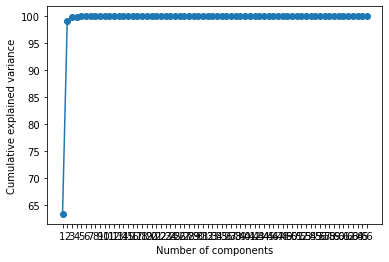

In [421]:
eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

plt.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
plt.xticks(np.arange(1,n_features+1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.show()

In [422]:
k = 4
W = eig_vecs_sorted[:k, :] # Projection matrix

print(W.shape)
print('{} components, captures {} of total variation'.format(k,cum_explained_variance[k-1]))

(4, 66)
4 components, captures 99.94000000000001 of total variation


### Generating the explanatory variables
Now the new set of explanatory variables will be the projected values of the prior variables on the set of principal components. 

In [423]:
X_proj = X_std.dot(W.T)

print(X_proj.shape)

(205, 4)


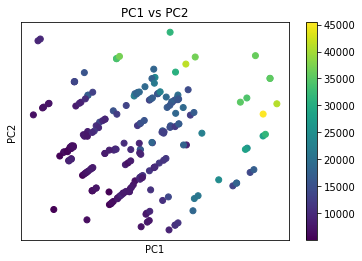

In [424]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], c = y)
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('PC1 vs PC2')
plt.colorbar()
plt.show()

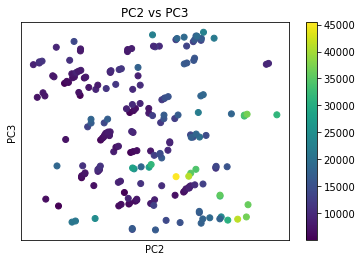

In [425]:
plt.scatter(X_proj[:, 1], X_proj[:, 2], c = y)
plt.xlabel('PC2'); plt.xticks([])
plt.ylabel('PC3'); plt.yticks([])
plt.title('PC2 vs PC3')
plt.colorbar()
plt.show()

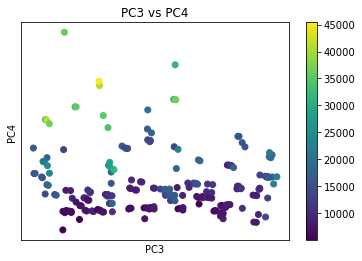

In [426]:
plt.scatter(X_proj[:, 2], X_proj[:, 3], c = y)
plt.xlabel('PC3'); plt.xticks([])
plt.ylabel('PC4'); plt.yticks([])
plt.title('PC3 vs PC4')
plt.colorbar()
plt.show()

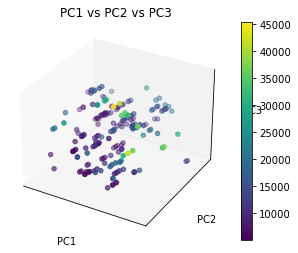

In [427]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the third axis set as X_proj[:, 1]
p=ax.scatter(X_proj[:, 1], X_proj[:, 2], X_proj[:, 0], c=y)


ax.set_xlabel('PC1')
ax.set_xticks([])  
ax.set_ylabel('PC2')
ax.set_yticks([])  
ax.set_zlabel('PC3')
ax.set_zticks([])  

ax.set_title('PC1 vs PC2 vs PC3')
fig.colorbar(p)

plt.show()


### Performing Linear Regression
Now we fit a linear regression model onto the new set of explanatory variables and observe the accuracy of the same on the set of test data.

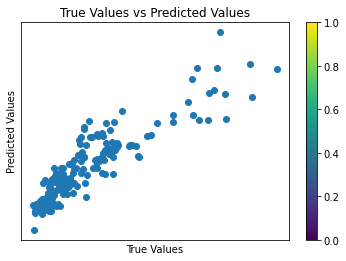

In [428]:
linear_model = LinearRegression()
linear_model.fit(X_proj, y)
y_pred = linear_model.predict(X_proj)
accuracy = linear_model.score(X_proj, y)

plt.scatter(y, y_pred)

plt.xlabel('True Values'); plt.xticks([])
plt.ylabel('Predicted Values'); plt.yticks([])
plt.title('True Values vs Predicted Values')
plt.colorbar()

Finally we observe the accuracy of the model as follows:

In [429]:
print("The accuracy of the linear regression model on the new set of explanatory variables is: ", accuracy*100, "%")

The accuracy of the linear regression model on the new set of explanatory variables is:  81.51731261756123 %
